# Music Recommendation System
## Notebook 01 : Exploratory Data Analysis

**Author**: Saad Abbas    
**Date**: 02 May 2019
____________________________________________________________________________________________________________________________

## Contents
- [1.0 Introduction](#introduction)
- [2.0 Exploratory Analysis](#eda)
    - [2.1 Exploring Songs](#songs)
    - [2.2 Exploring Members](#members)
    - [2.3 Exploring Train Dataset](#train)
- [3.0 Conclusion](#conclusion)
____________________________________________________________________________________________________________________________

<a id='introduction'></a>
## 1.0 Introduction
This project is based on the [KK-Box Music Recommendation Challenge](https://www.kaggle.com/c/kkbox-music-recommendation-challenge) hosted on Kaggle. I have split it into two notebooks (preliminary analysis and predictive modelling).

This notebook will focus on the Exploratory Data Analysis of our available datasets. Here I will do all the analysis, transformations and modifications required to make the data ready for modelling.

The key deliverables of this notebook are as follows:
- Clear understanding of the layout of available data
- Any data cleaning, feature engineering or transformation required to make the data ready for modelling
- Save the final transformed compliled dataset as a separate CSV file

The below is copied from the Kaggle competition webpage describing the challenge:
_____________________________________________________________________________________________
>In this task, you will be asked to predict the chances of a user listening to a song repetitively after the first observable listening event within a time window was triggered. If there are recurring listening event(s) triggered within a month after the user’s very first observable listening event, its target is marked 1, and 0 otherwise in the training set. The same rule applies to the testing set.
KKBOX provides a training data set consists of information of the first observable listening event for each unique user-song pair within a specific time duration. Metadata of each unique user and song pair is also provided. The use of public data to increase the level of accuracy of your prediction is encouraged.
The train and the test data are selected from users listening history in a given time period. Note that this time period is chosen to be before the WSDM-KKBox Churn Prediction time period. The train and test sets are split based on time, and the split of public/private are based on unique user/song pairs.
>#### train.csv
>- msno: user id
>- song_id: song id
>- source_system_tab: the name of the tab where the event was triggered. System tabs are used to categorize KKBOX mobile apps functions. For example, tab my library contains functions to manipulate the local storage, and tab search contains functions relating to search.
>- source_screen_name: name of the layout a user sees.
>- source_type: an entry point a user first plays music on mobile apps. An entry point could be album, online-playlist, song .. etc.
>- target: this is the target variable. target=1 means there are recurring listening event(s) triggered within a month after the user’s very first observable listening event, target=0 otherwise.

>#### test.csv
>- id: row id (will be used for submission)
>- msno: user id
>- song_id: song id
>- source_system_tab: the name of the tab where the event was triggered. System tabs are used to categorize KKBOX mobile apps functions. For example, tab my library contains functions to manipulate the local storage, and tab search contains functions relating to search.
>- source_screen_name: name of the layout a user sees.
>- source_type: an entry point a user first plays music on mobile apps. An entry point could be album, online-playlist, song .. etc.

>#### members.csv
>User information.
>- msno
>- city
>- bd: age. Note: this column has outlier values, please use your judgement.
>- gender
>- registered_via: registration method
>- registration_init_time: format %Y%m%d
>- expiration_date: format %Y%m%d

>#### songs.csv
>The songs. Note that data is in unicode.
>- song_id
>- song_length: in ms
>- genre_ids: genre category. Some songs have multiple genres and they are separated by |
>- artist_name
>- composer
>- lyricist
>- language

>#### song_extra_info.csv
>- song_id
>- song name - the name of the song.
>- isrc - International Standard Recording Code, theoretically can be used as an identity of a song. However, what worth to note is, ISRCs generated from providers have not been officially verified; therefore the information in ISRC, such as country code and reference year, can be misleading/incorrect. Multiple songs could share one ISRC since a single recording could be re-published several times.
_____________________________________________________________________________________________

In [121]:
# Import All libraries required for this notebook

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from tqdm import tqdm
from pathlib import Path
import warnings

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')

<a id='eda'></a>
## 2.0 Exploratory Data Analysis
Since this project is a demonstration of how recommendation systems work, I will be working on a partial set of the Kaggle competition data. The same algorithms can easily be scaled up for larger datasets as desired.

In [77]:
# Loading in all CSV files
datapath = Path('../datasets/')

songs = pd.read_csv(datapath / 'songs_small.csv')
members = pd.read_csv(datapath / 'members_small.csv')
train = pd.read_csv(datapath / 'train_small.csv')

<a id='songs'></a>
### 2.1 Exploring Songs

In [78]:
songs.head()

,song_id,song_length,genre_ids,artist_name,composer,lyricist,language,name,isrc
0,o0kFgae9QtnYgRkVPqLJwa05zIhRlUjfF7O1tDw0ZDU=,197328.0,444,BLACKPINK,TEDDY| FUTURE BOUNCE| Bekuh BOOM,TEDDY,31.0,PLAYING WITH FIRE,NaN
1,DwVvVurfpuz+XPuFvucclVQEyPqcpUkHR0ne1RQzPs0=,231781.0,465,SUPER JUNIOR,NaN,NaN,31.0,SORRY| SORRY,NaN
2,dKMBWoZyScdxSkihKG+Vf47nc18N9q4m58+b4e7dSSE=,273554.0,465,S.H.E,湯小康,徐世珍,3.0,愛我的資格,TWC950206108
3,W3bqWd3T+VeHFzHAUfARgW9AvVRaF4N5Yzm4Mr6Eo/o=,140329.0,726,貴族精選,Traditional,Traditional,52.0,Mary Had a Little Lamb,NaN
4,kKJ2JNU5h8rphyW21ovC+RZU+yEHPM+3w85J37p7vEQ=,235520.0,864|857|850|843,貴族精選,Joe Hisaishi,Hayao Miyazaki,17.0,となりのトトロ,NaN


I will make the following changes in the songs dataframe before beginning the analysis process:
- Convert the language numerical codes to actual language names (based on randomly selected manual Google translate searches)
- Convert the song lengths to minutes (so that it makes more numerical sense)
- Create a binned column for songs length, categorizing the songs by the length
- Fill all the null values with either 'na' or '0' based on column dtype

In [79]:
# Convert language column to actual languages:
songs['language'].fillna(0, inplace=True)

lang_dict = {3 :  'Chinese', 52 : 'English', 31 : 'Korean', -1 : 'N/A', 17 : 'Japanese', 10 : 'Chinese-2', 
             24 : 'Chinese-3', 59 : 'Chinese-4', 45 : 'Thai', 38 : 'Hindi', 0 :  'Missing'}

songs['language'] = songs['language'].map(lambda x: lang_dict[x])

# Convert song length to minutes and bin by length
songs['song_length'] = songs['song_length'] / 60000

def song_length_groups(x):
    if x < 2:
        return 'less than 2 min'
    elif x < 4.5:
        return '2 to 4.5 min'
    elif x < 7:
        return '4.5 to 7 min'
    elif x < 30:
        return '7 to 30 min'
    else:
        return 'greater than 30 min'

songs['song_length_group'] = songs['song_length'].map(lambda x: song_length_groups(x))


# Fill categorical nulls with 'na':
for col in ['genre_ids','composer','lyricist','language','name', 'isrc']:
    songs[col] = songs[col].fillna('na')

Now let us visualize the data:

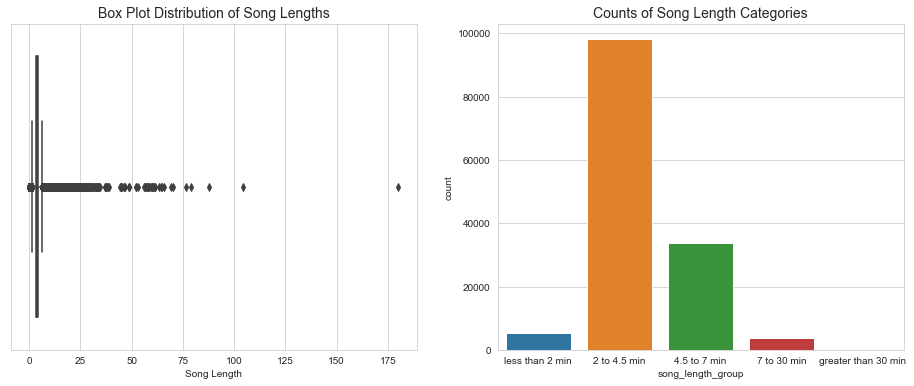

In [80]:
# Plotting song lengths
fig, ax = plt.subplots(1,2, figsize=(16,6))
sns.boxplot(data=songs['song_length'], ax=ax[0], orient='h')
sns.countplot(songs['song_length_group'], ax=ax[1], order=['less than 2 min', '2 to 4.5 min', '4.5 to 7 min', '7 to 30 min', 
                                                           'greater than 30 min'])
ax[0].set_title('Box Plot Distribution of Song Lengths', fontsize=14)
ax[0].get_yaxis().set_ticks([])
ax[0].set_xlabel('Song Length')
ax[1].set_title('Counts of Song Length Categories', fontsize=14)
plt.show()

Although most songs are in the 2 to 7 minute range as expected, there are a few songs which go over the the expected length span (e.g. the maximum length of a song is around 3 hours, and it checks out on Google so it is not a mistake in the data).

In [81]:
print('Number of Artists: {:,}'.format(songs['artist_name'].nunique()))

Number of Artists: 21,118


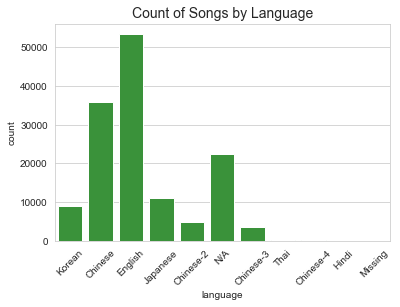

In [82]:
# Plotting count of language
sns.countplot(songs['language'], color='C2')
plt.xticks(rotation=45)
plt.title('Count of Songs by Language', fontsize=14)
plt.show()

The above graph shows us that the majority of songs in the repository are English.

A large portion of songs have missing value for language, however it is not a simple task to identify the language of the song itself (e.g. the song or artist name may be in English, but the song itself may be in a different langauge).

Moving on the genre_ids column, the first issue is that many songs have multiple genres assigned to them. As this is actually the case for most songs, we cannot remove the additional genres as they are an identifier of that song. Below I have separated the genres in different columns for ease of exploration. Furthermore, I have compiled and visualized which genre appears most in the database.

In [83]:
# Identify unique genres and occurence in song database
genre_list_series = songs['genre_ids'].str.split('|', expand=True)
genre_list_series.columns = ['genre_id1', 'genre_id2', 'genre_id3', 'genre_id4', 
                             'genre_id5', 'genre_id6', 'genre_id7', 'genre_id8']
genre_list = []
for column in genre_list_series.columns:
    genre_list = genre_list + list(genre_list_series[column])

In [84]:
def genre_counts(df, num=40):
    genre_total_count = pd.concat([df['genre_id1'].value_counts(), df['genre_id2'].value_counts(),
                                   df['genre_id3'].value_counts(), df['genre_id4'].value_counts(),
                                   df['genre_id5'].value_counts(), df['genre_id6'].value_counts(),
                                   df['genre_id7'].value_counts(), df['genre_id8'].value_counts()], axis=1, sort=False)

    genre_total_count = genre_total_count.fillna(0)

    genre_total_count['sum'] = genre_total_count['genre_id1'] + genre_total_count['genre_id2'] + genre_total_count['genre_id3'] + \
                           genre_total_count['genre_id4'] + genre_total_count['genre_id5'] + genre_total_count['genre_id6'] + \
                           genre_total_count['genre_id7'] + genre_total_count['genre_id8']

    genre_total_count = genre_total_count.reset_index().sort_values('sum', ascending=False)
    genre_total_count = genre_total_count.drop(['genre_id1', 'genre_id2', 'genre_id3', 'genre_id4', 
                                                'genre_id5', 'genre_id6', 'genre_id7', 'genre_id8'], axis=1)
    return genre_total_count[:num]

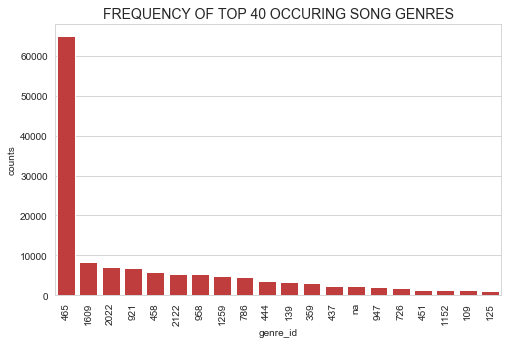

In [85]:
fig = plt.figure(figsize=(8,5))
sns.barplot(x='index', y='sum', data=genre_counts(genre_list_series, num=20), color='C3')
plt.xticks(rotation=90)
plt.title('FREQUENCY OF TOP 40 OCCURING SONG GENRES', fontsize=14)
plt.xlabel('genre_id')
plt.ylabel('counts')
plt.show()

The highest occurring genres in the database are 465, 968, 1609 and 2022. A quick Google search for those songs / artists show that these are predominantly all pop music, showing that KK-Box has a large selection of pop songs.

<a id='members'></a>
### 2.2 Exploring Members

In [86]:
members.head()

,msno,city,bd,gender,registered_via,registration_init_time,expiration_date,reg_year,exp_year,age_group
0,XQxgAYj3klVKjR3oxPPXYYFp4soD4TuBghkhMTD4oTw=,1,5,Missing,7,2011-08-20,2017-09-20,2011,2017,less than 7
1,UizsfmJb9mV54qE9hCYyU07Va97c0lCRLEQX3ae+ztM=,1,5,Missing,7,2015-06-28,2017-06-22,2015,2017,less than 7
2,D8nEhsIOBSoE6VthTaqDX8U6lqjJ7dLdr72mOyLya2A=,1,5,Missing,4,2016-04-11,2017-07-12,2016,2017,less than 7
3,pg6bT2XZkSP1TDBy4qn3HBPY/HffKQ/bg8WIISQYBSY=,1,5,Missing,7,2016-01-30,2017-09-30,2016,2017,less than 7
4,kfk1AdTNH2dNqF5LzIs4e0vwGPejw2jrnFjJlcYnEgk=,1,5,Missing,7,2011-01-11,2017-09-30,2011,2017,less than 7


I will make the following changes in the members dataframe before beginning the analysis process:
- Convert the 'city' and 'registered_via' numbers to strings as they are identifiers and not value indicators.
- The 'registration_init_time' and 'expiration_date' does not look like a very useful metric for recommendation evaluation. However for now I will convert them to datetime. I will also make separate columns for the year for these columns, and evaluate if that makes for a better recommendation identifier than the full dates.
- I will make a separate column for age_group based on 'bd' (which has some wierd outliers as we will see later).
- There are a lot of missing values in the 'gender' column. Unfortunately there is no meaninful way to impute this information, so I will just update missing values with 'Missing'.

In [87]:
# Convert the city and registered_via to strings:
members['city'] = members['city'].astype(str)
members['registered_via'] = members['registered_via'].astype(str)

# Change reg/exp dates to datetime and extract years:
members['reg_year'] = members['registration_init_time'].map(lambda x: int(str(x)[:4]))
members['exp_year'] = members['expiration_date'].map(lambda x: int(str(x)[:4]))

for col in ['registration_init_time', 'expiration_date']:
    members[col] = members[col].map(lambda x: datetime.strptime(str(x), '%Y-%m-%d')).copy()
    
# Make new column for age_group
def age_groups(x):
    if x < 7:
        return 'less than 7'
    elif x < 21:
        return '7 - 20'
    elif x < 45:
        return '21 - 44'
    elif x < 71:
        return '45 - 70'
    else:
        return 'greater than 70'

members['age_group'] = members['bd'].map(lambda x: age_groups(x))

In [88]:
# Fill missing gender values
members['gender'] = members['gender'].fillna('Missing')

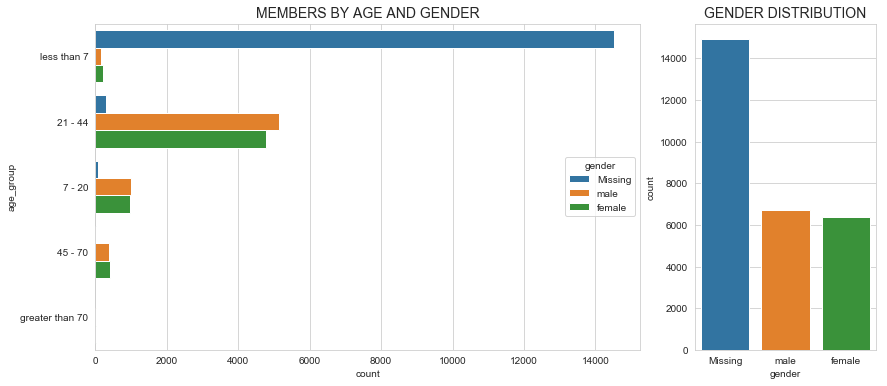

In [89]:
# Plotting gender and age distributions
fig, ax = plt.subplots(1,2, figsize=(14,6), gridspec_kw={'width_ratios': [3, 1]})
sns.countplot(y='age_group', data=members, hue='gender', orient='h', ax=ax[0])
sns.countplot(x='gender', data=members, orient='v', ax=ax[1])
ax[0].set_title('MEMBERS BY AGE AND GENDER', fontsize=14)
ax[1].set_title('GENDER DISTRIBUTION', fontsize=14)
plt.subplots_adjust(wspace=0.15)
plt.show()

There is a large class of subscribers whose gender is unidentified and age is unreasonably low. Again, unfortunately there is no simple way to impute this information from the available data. The other age groups exhibit expected distributions, with the majority of subscribers in the earning age bracket.

A few observations for the dataset:
- There is a single case where the exp_year is BEFORE the reg_year. For this, I have matched both years to make the difference non-negative.
- There are some negative ages in the dataset. I have changed all of them to 5, to keep the binning same.
- There are quite a few unrealistically high ages. I have changed all of them to 80.

In [90]:
# Single date outlier moved to give the graph more relevance
members.loc[(members['exp_year']-members['reg_year']) < 0, 'exp_year'] = 2014
members.loc[members['registration_init_time']>members['expiration_date'], 'expiration_date'] = datetime(2014, 5, 1)

# Update the outlier ages
members.loc[members['bd']<5, 'bd'] = 5
members.loc[members['bd']>70, 'bd'] = 80

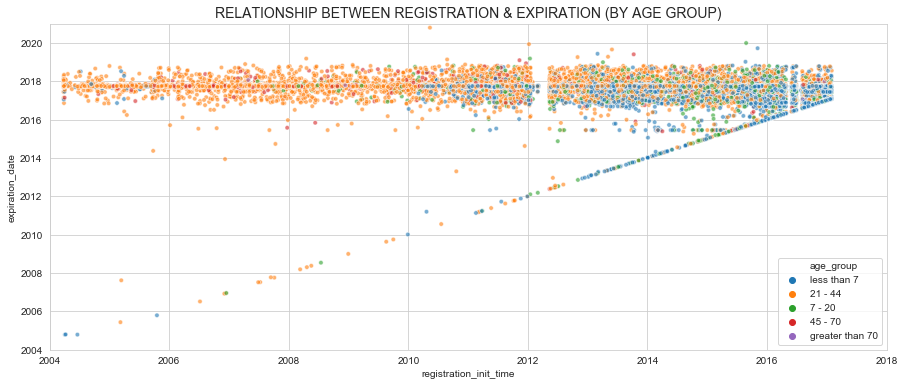

In [91]:
# Plotting registration and expiration dates
fig = plt.figure(figsize=(15,6))
sns.scatterplot(x='registration_init_time', y='expiration_date', data=members, hue='age_group', s=20, alpha=0.6)
plt.xlim(datetime(2004,1,1), datetime(2018,1,1))
plt.ylim(datetime(2004,1,1), datetime(2021,1,1))
plt.title('RELATIONSHIP BETWEEN REGISTRATION & EXPIRATION (BY AGE GROUP)', fontsize=14)
plt.show()

Many subscribers have registered and terminated their subscriptions in the same year (as shown by the bottom sloped line). Moreover, a significant number of subscribers seem to have expired their subscriptions around 2017-2018. This points to a churn issue and is out of the scope of this analysis (I plan to do it at a later date, using the KK-Box Churn Prediction challenge).

It can be seen that most of the unidentified low-age subscribers start appearing after 2010 and increase in density over time. Coupled with this, there are some gaps in the chart where no registrations or cancellations have occurred. I believe both of these issues may point to some software issue in the system; however with the available data there is no way to be sure.

In [92]:
members['registered_via'].value_counts()

7     8617
9     7962
4     7215
3     4189
13      54
Name: registered_via, dtype: int64

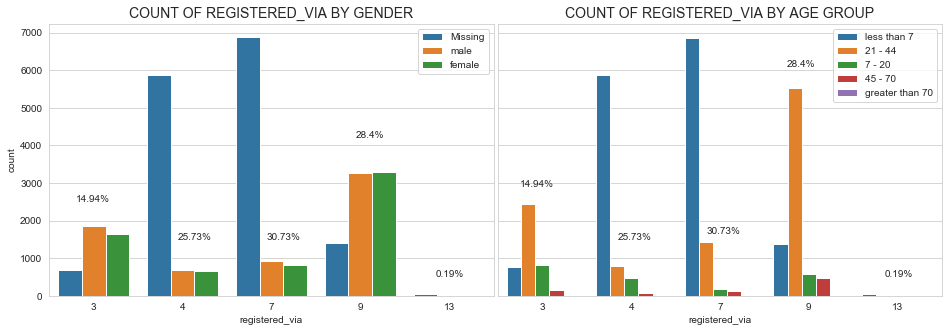

In [93]:
# Plotting registered_via column against age and gender
fig, ax = plt.subplots(1,2, figsize=(16,5), sharey=True)
sns.countplot(x='registered_via', data=members, hue='gender', order=['3','4','7','9','13'], ax=ax[0])
sns.countplot(x='registered_via', data=members, hue='age_group', order=['3','4','7','9','13'], ax=ax[1])

pctgs = members['registered_via'].value_counts(normalize=True).to_dict()

ax[0].legend(loc='upper right')
ax[0].set_title('COUNT OF REGISTERED_VIA BY GENDER', fontsize=14)
ax[0].text(-0.2, 2500, str(round(pctgs['3']*100,2))+'%')
ax[0].text(0.95, 1500, str(round(pctgs['4']*100,2))+'%')
ax[0].text(1.95, 1500, str(round(pctgs['7']*100,2))+'%')
ax[0].text(2.95, 4200, str(round(pctgs['9']*100,2))+'%')
ax[0].text(3.85, 500, str(round(pctgs['13']*100,2))+'%')

ax[1].legend(loc='upper right')
ax[1].set_title('COUNT OF REGISTERED_VIA BY AGE GROUP', fontsize=14)
ax[1].text(-0.25, 2900, str(round(pctgs['3']*100,2))+'%')
ax[1].text(0.85, 1500, str(round(pctgs['4']*100,2))+'%')
ax[1].text(1.85, 1650, str(round(pctgs['7']*100,2))+'%')
ax[1].text(2.75, 6100, str(round(pctgs['9']*100,2))+'%')
ax[1].text(3.85, 500, str(round(pctgs['13']*100,2))+'%')
ax[1].set_ylabel('')
plt.subplots_adjust(wspace=0.01)
plt.show()

Platforms '4' and '7' are apparently the favorite registration methods for the low-age subscribers. Those in the earning age bracket seem to prefer platform '3' and '9', and are generally equally distributed for males and females.

Unfortunately, the platforms have been encoded to numbers by the data providers, and it is not possible to derive much more insight from these charts as to why this may be happening without knowing the actual platform the numbers represent.

**Final members dataframe:**

In [94]:
members.head()

,msno,city,bd,gender,registered_via,registration_init_time,expiration_date,reg_year,exp_year,age_group
0,XQxgAYj3klVKjR3oxPPXYYFp4soD4TuBghkhMTD4oTw=,1,5,Missing,7,2011-08-20,2017-09-20,2011,2017,less than 7
1,UizsfmJb9mV54qE9hCYyU07Va97c0lCRLEQX3ae+ztM=,1,5,Missing,7,2015-06-28,2017-06-22,2015,2017,less than 7
2,D8nEhsIOBSoE6VthTaqDX8U6lqjJ7dLdr72mOyLya2A=,1,5,Missing,4,2016-04-11,2017-07-12,2016,2017,less than 7
3,pg6bT2XZkSP1TDBy4qn3HBPY/HffKQ/bg8WIISQYBSY=,1,5,Missing,7,2016-01-30,2017-09-30,2016,2017,less than 7
4,kfk1AdTNH2dNqF5LzIs4e0vwGPejw2jrnFjJlcYnEgk=,1,5,Missing,7,2011-01-11,2017-09-30,2011,2017,less than 7


<a id='train'></a>
### 2.3 Exploring Train Dataset


In [95]:
train.head(3)

,msno,song_id,source_system_tab,source_screen_name,source_type,target
0,9VXz26ESh7NFuiMGGjMAdlEkBfA1kDsCZh/2y2k6fQE=,yFegcegHtPQFf47Q6RQpX24fg88XcLQoLwRlhMZNS5o=,my library,Album more,album,1
1,U+TmVXpu5LjTysmVIkWORwm8COIEEpSW3JKjgWjTexs=,P3Xxqogqa9LruXal+6xXZ54VEdO2LXUrwY8Woqeml8o=,my library,My library,local-library,1
2,eEUD+vczIGMiEvN6JylGDTXTl6Tnzgv+d4btsVI7lgM=,JX0x5urJlfmIs6SbaU6Ixc6EJ4Nb2rh+XsjFnq0mqjw=,my library,Local playlist more,local-library,0


In [96]:
train.shape

(1106612, 6)

Let us merge the final songs and members dataframes to the training dataframe and visualize if any features correspond to higher repeat song listens.

In [97]:
final_train = pd.merge(train, songs, on='song_id', how='left')
final_train = pd.merge(final_train, members, on='msno', how='left')

In [98]:
# Split final set on target value
final_train_1 = final_train[final_train['target']==1].copy()
final_train_0 = final_train[final_train['target']==0].copy()

Let us make a quick plot to check the distribution of how many songs are repeated by a user.

In [99]:
songs_listened = final_train.groupby('msno')['target'].count()
songs_repeated = final_train.groupby('msno')['target'].sum()

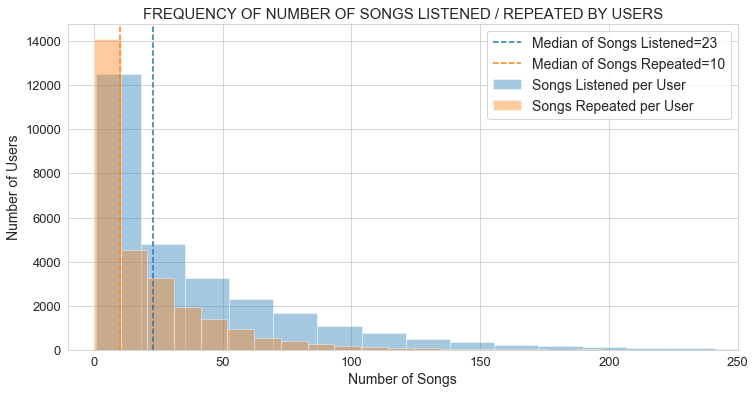

In [111]:
fig = plt.figure(figsize=(12,6))
sns.distplot(songs_listened, kde=False, label='Songs Listened per User', color='C0')
sns.distplot(songs_repeated, kde=False, label='Songs Repeated per User', color='C1')
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.xlabel('Number of Songs', fontsize=14)
plt.ylabel('Number of Users', fontsize=14)
plt.title('FREQUENCY OF NUMBER OF SONGS LISTENED / REPEATED BY USERS', fontsize=15)
plt.xlim(-10, 250)
plt.axvline(x=songs_listened.median(), color='C0', linestyle='--', 
            label='Median of Songs Listened={:.0f}'.format(songs_listened.median()))
plt.axvline(x=songs_repeated.median(), color='C1', linestyle='--', 
            label='Median of Songs Repeated={:.0f}'.format(songs_repeated.median()))
plt.legend(fontsize=14)
plt.show()

The number of unique songs a user a listened to in the timeframe of this data window tends to bunch up towards the lower spectrum, with the greater majority being centred around 15-20 songs. Of those, half are seen to have repeat listens. This is a significant skew and will definitely affect the recommendation prediction process.

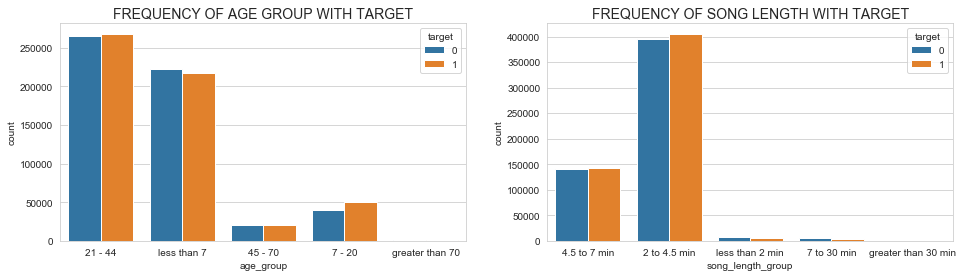

In [101]:
fig, ax = plt.subplots(1,2, figsize=(16,4))
sns.countplot(x='age_group', data=final_train, hue='target', ax=ax[0])
sns.countplot(x='song_length_group', data=final_train, hue='target', ax=ax[1])
ax[0].set_title('FREQUENCY OF AGE GROUP WITH TARGET', fontsize=14)
ax[1].set_title('FREQUENCY OF SONG LENGTH WITH TARGET', fontsize=14)
plt.show()

The above charts show that age or song length alone are not an identifier for repeat plays. We need to dig deeper and discover if there are any combinations which might show us where there might be a difference.

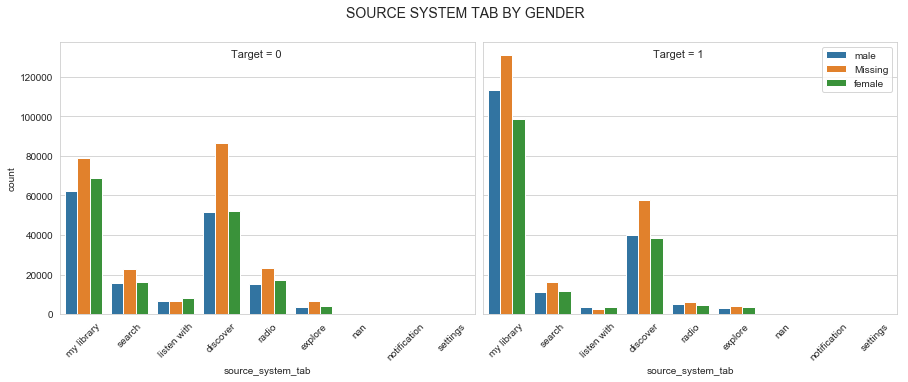

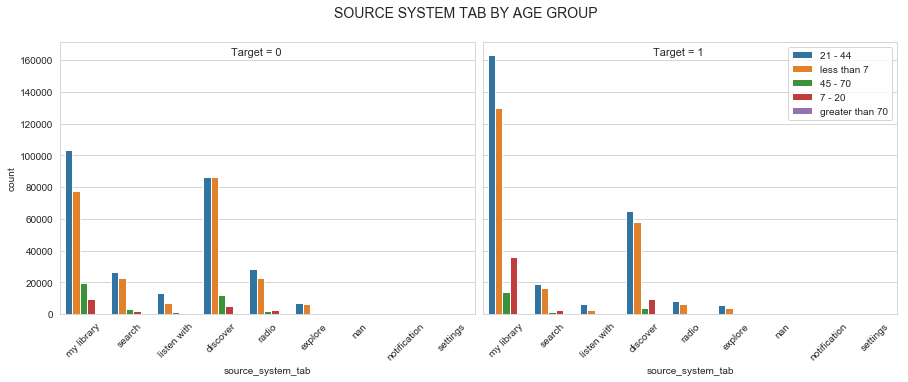

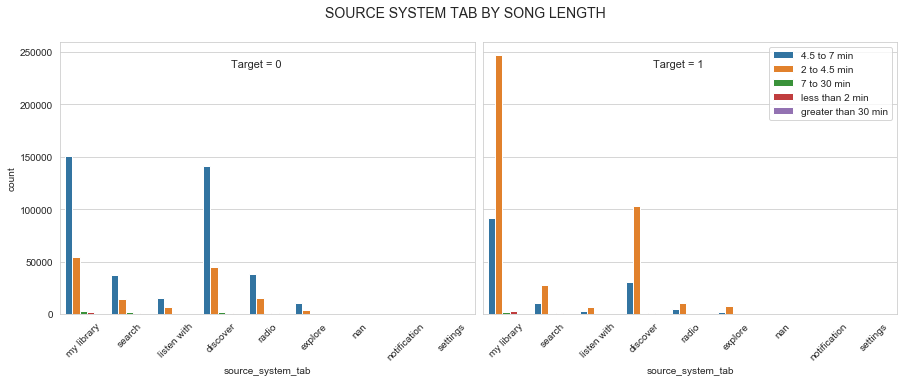

In [102]:
# Plotting source_system_tab against by gender / age_group / song_length
plot_for = 'source_system_tab'
order_list = list(final_train[plot_for].unique())

looper = [('gender', 130000, 'SOURCE SYSTEM TAB BY GENDER'), 
          ('age_group', 163000, 'SOURCE SYSTEM TAB BY AGE GROUP'), 
          ('song_length_group', 235000, 'SOURCE SYSTEM TAB BY SONG LENGTH')]

for hue_, height_, label_ in looper:
    fig, ax = plt.subplots(1,2, figsize=(15, 5), sharey=True)
    sns.countplot(x=plot_for, data=final_train_0, ax=ax[0], hue=hue_, order=order_list)
    sns.countplot(x=plot_for, data=final_train_1, ax=ax[1], hue=hue_, order=order_list)
    ax[0].legend_.remove()
    ax[1].legend(loc='upper right')
    ax[1].set_ylabel('')
    ax[0].text(3.2, height_, 'Target = 0', fontsize=11)
    ax[1].text(3.2, height_, 'Target = 1', fontsize=11)
    ax[0].tick_params(axis='x', labelrotation=45)
    ax[1].tick_params(axis='x', labelrotation=45)
    fig.suptitle(label_, fontsize=14)
    plt.subplots_adjust(wspace=0.02)
    plt.show()

Based on the above plots for source_system_tab, we can observe the following:
- There is no significant difference in behaviours between males and females.
- Subsribers who have repeat song listens generally tend to prefer 'my library', with less of an emphasis on 'radio' and 'listen with'.
- Although 'discover' has significant usage, it does not seem to contribute to a repeated song listen.
- Most of the repeat listens are by users in the 21 - 44 age bracket. There is also a significant difference for repeat listens for the  less than 7 age group. However, the members in age group 7 - 20 tend to not have much repeat listens.
- 4.5 to 7 min songs generally have much lower repeat listens, whereas songs in the 2 to 4.5 min length bracket have a much higher probability of having a repeated listen.

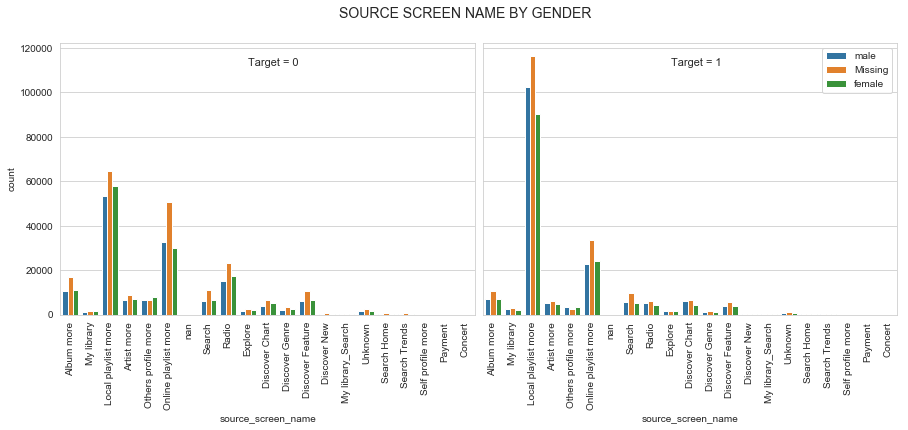

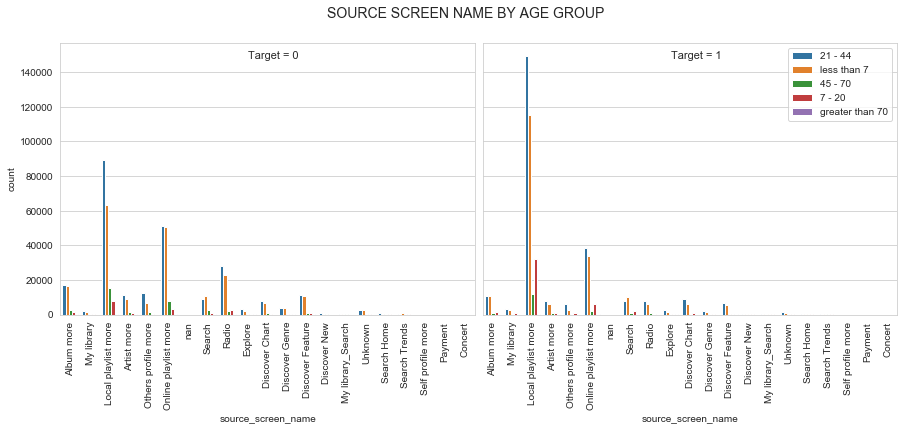

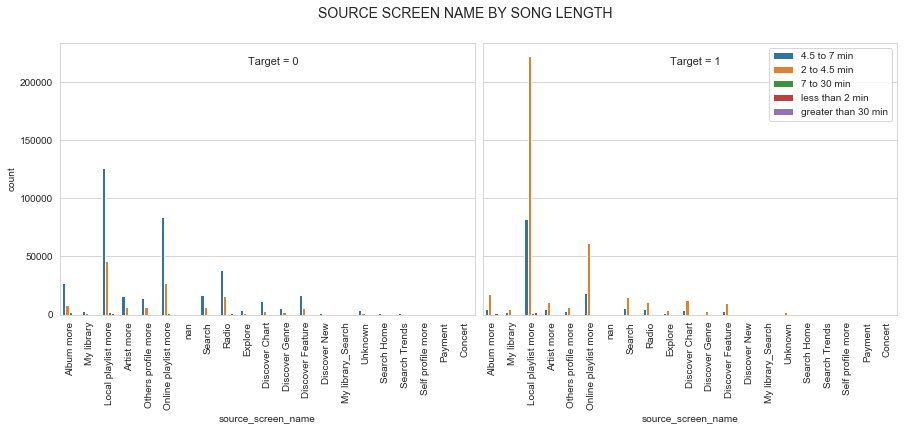

In [103]:
# Plotting source_screen_name against by gender / age_group / song_length
plot_for = 'source_screen_name'
order_list = list(final_train[plot_for].unique())

looper = [('gender', 112000, 'SOURCE SCREEN NAME BY GENDER'), 
          ('age_group', 148000, 'SOURCE SCREEN NAME BY AGE GROUP'), 
          ('song_length_group', 215000, 'SOURCE SCREEN NAME BY SONG LENGTH')]

for hue_, height_, label_ in looper:
    fig, ax = plt.subplots(1,2, figsize=(15, 5), sharey=True)
    sns.countplot(x=plot_for, data=final_train_0, ax=ax[0], hue=hue_, order=order_list)
    sns.countplot(x=plot_for, data=final_train_1, ax=ax[1], hue=hue_, order=order_list)
    ax[0].legend_.remove()
    ax[1].legend(loc='upper right')
    ax[1].set_ylabel('')
    ax[0].text(9, height_, 'Target = 0', fontsize=11)
    ax[1].text(9, height_, 'Target = 1', fontsize=11)
    ax[0].tick_params(axis='x', labelrotation=90)
    ax[1].tick_params(axis='x', labelrotation=90)
    fig.suptitle(label_, fontsize=14)
    plt.subplots_adjust(wspace=0.02)
    plt.show()

Based on the above source_screen_name charts we can observe the following:
- There is a higher usage of 'Local playlist more' and 'Online playlist more' compared to other classes. 
- 'Local playlist more' shows a high correlation with our target. 'Online playlist more' shows a slightly negative impact.
- Age groups and songs lengths have similar behaviours as seen in source_system_tab.

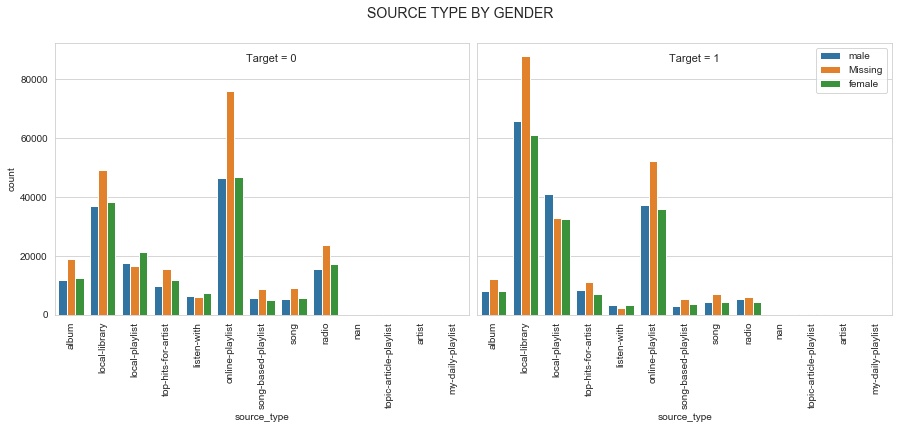

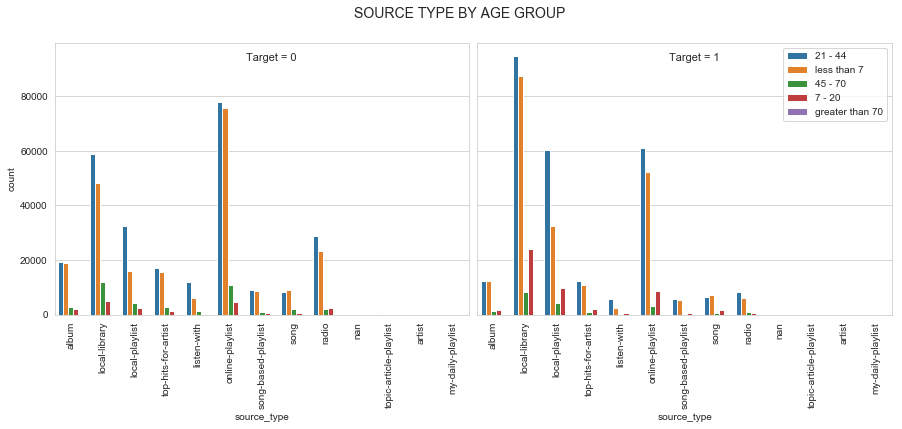

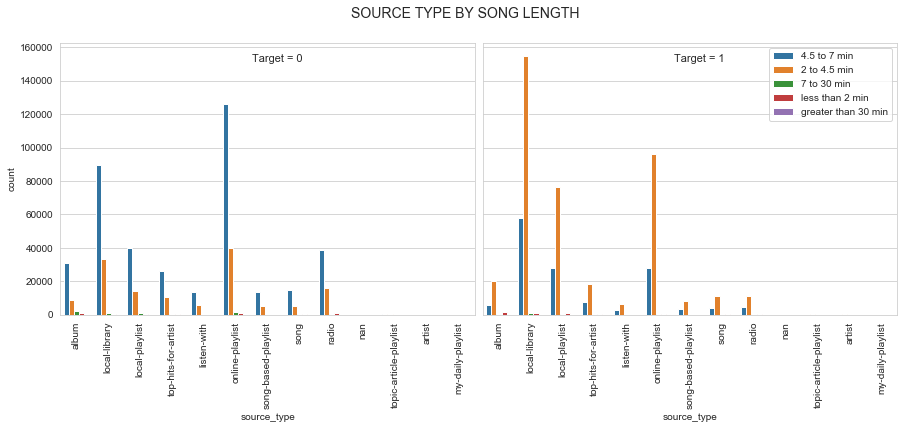

In [104]:
# Plotting source_type against by gender / age_group / song_length
plot_for = 'source_type'
order_list = list(final_train[plot_for].unique())

looper = [('gender', 86000, 'SOURCE TYPE BY GENDER'), 
          ('age_group', 93000, 'SOURCE TYPE BY AGE GROUP'), 
          ('song_length_group', 151000, 'SOURCE TYPE BY SONG LENGTH')]

for hue_, height_, label_ in looper:
    fig, ax = plt.subplots(1,2, figsize=(15, 5), sharey=True)
    sns.countplot(x=plot_for, data=final_train_0, ax=ax[0], hue=hue_, order=order_list)
    sns.countplot(x=plot_for, data=final_train_1, ax=ax[1], hue=hue_, order=order_list)
    ax[0].legend_.remove()
    ax[1].legend(loc='upper right')
    ax[1].set_ylabel('')
    ax[0].text(5.5, height_, 'Target = 0', fontsize=11)
    ax[1].text(5.5, height_, 'Target = 1', fontsize=11)
    ax[0].tick_params(axis='x', labelrotation=90)
    ax[1].tick_params(axis='x', labelrotation=90)
    fig.suptitle(label_, fontsize=14)
    plt.subplots_adjust(wspace=0.02)
    plt.show()

Based on the above source_type charts we can observe the following:
- There is a higher usage of 'online-playlist', 'local-playlist', and 'local-library' compared to other classes. 
- There is a highest probability of repeat listens for 'local-playlist' and 'local-library'.
- Age groups and songs lengths have similar behaviours as seen in source_system_tab.

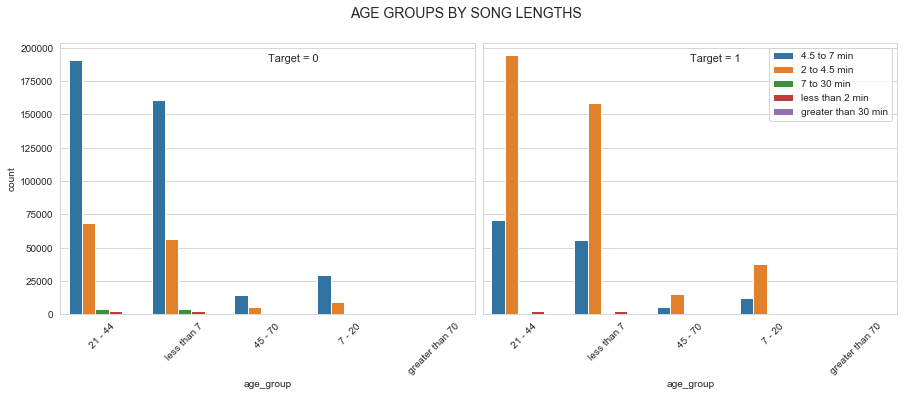

In [105]:
# Plotting age_group with song_length
order_list = list(final_train['age_group'].unique())

fig, ax = plt.subplots(1,2, figsize=(15, 5), sharey=True)
sns.countplot(x='age_group', data=final_train_0, ax=ax[0], hue='song_length_group', order=order_list)
sns.countplot(x='age_group', data=final_train_1, ax=ax[1], hue='song_length_group', order=order_list)
ax[0].legend_.remove()
ax[1].legend(loc='upper right')
ax[1].set_ylabel('')
ax[0].text(2, 190000, 'Target = 0', fontsize=11)
ax[1].text(2, 190000, 'Target = 1', fontsize=11)
ax[0].tick_params(axis='x', labelrotation=45)
ax[1].tick_params(axis='x', labelrotation=45)
fig.suptitle('AGE GROUPS BY SONG LENGTHS', fontsize=14)
plt.subplots_adjust(wspace=0.02)
plt.show()

We can see from the above charts that most of the listeners are focused in the less than 7 and in the 21-44 age groups. Also, it can ge generally seen that 2 to 4.5 min songs are play repeated much more than 4.5 to 7 min songs.

<a id='conclusion'></a>
## 3.0 Conclusion

This notebook covered the basic preliminary analysis required to understand the contents of the provided data. Notebook 02 will cover the modelling and prediction for the train and test cases.

In [109]:
songs.to_csv('../datasets/songs_small_modified.csv', index=False)